### There are over 1000 samples from 135 locations in the data set
#### It is essential that we can indentify extreme values and identify the cause

1. Misidentification of objects can lead to false results
2. Volunteers have different expertise and training
3. Training and feedback is essential to getting a consistent data set

### Key assumptions:

1. Sample locations with common properties should have similar distributions for objects or groups of objects
2. Siginifigant differences in the distributions could be attributed to misidentification of objects
3. If the items are properly identified, then there are other factors that contribute to the difference

#### This is the first step to determining cause or origin of the objects found on the water line.  Locations with extreme values can be compared for other correlations including : population density, water level etc...

#### We will compare the groups of objects that have similar origins from all the lakes in the survey:

1. Direct consumer: Candy wrappers, lolipop sticks, bottle caps(metal and plastic), straws
2. Industry & constriction: Fragmented Styrofoam and plastic, plastic construction waste, industrial sheeting
3. Infrastructure - Cotton swabs, tampons & maxi pads, tampon applicators, media filters


#### Load the libraries needed:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import os
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm #<----- this library has a bunch of tools to use on the poisson process
here = os.getcwd()
data = here + '/data/'
here

'/home/mw-shovel/web/notes/notes-hammerdirt.ch'

#### Get the data and any other 'objects' required

#### The freshest data is available here http://mwshovel.pythonanywhere.com/dirt/beach_litter.html check under the read me section. "Click here to get data in csv format" will open a modal with links to the data used here.

> This data has been cleaned, which means any record that gives a 'nan' value when quantity is divided by length has been discarded.

In [2]:
# this has already been downloaded for this note book

obj_totals = pd.read_csv(data + 'code_data.csv')
day_totals = pd.read_csv(data + 'daily_data.csv')
location = pd.read_csv(data + 'site_data.csv')

In [3]:
location[:3]

,Unnamed: 0,city,latitude,location,longitude,post,project_id,water,water_name
0,0,La Tour-de-Peilz,46.447216,Anarchy Beach,6.859612,1814,MCBP,l,Lac Léman
1,1,Vevey,46.462099,Arabie,6.834972,1800,MCBP,l,Lac Léman
2,2,La Tour-de-Peilz,46.450507,Bain des Dames,6.858092,1814,MCBP,l,Lac Léman


In [4]:
# clean this up a little
def give_columns(a):
    return a.columns
a = give_columns(location)
b = give_columns(day_totals)
c = give_columns(obj_totals)

In [5]:
location = location[a[1:]].copy()
location[:3]

,city,latitude,location,longitude,post,project_id,water,water_name
0,La Tour-de-Peilz,46.447216,Anarchy Beach,6.859612,1814,MCBP,l,Lac Léman
1,Vevey,46.462099,Arabie,6.834972,1800,MCBP,l,Lac Léman
2,La Tour-de-Peilz,46.450507,Bain des Dames,6.858092,1814,MCBP,l,Lac Léman


In [6]:
day_totals = day_totals[b[1:]]
obj_totals = obj_totals[c[1:]]

In [7]:
# take only locations that are on lakes
def get_lakes(a):
    return a.loc[a.water == 'l']
lakes = get_lakes(location).copy()
lakes[:10]

,city,latitude,location,longitude,post,project_id,water,water_name
0,La Tour-de-Peilz,46.447216,Anarchy Beach,6.859612,1814,MCBP,l,Lac Léman
1,Vevey,46.462099,Arabie,6.834972,1800,MCBP,l,Lac Léman
2,La Tour-de-Peilz,46.450507,Bain des Dames,6.858092,1814,MCBP,l,Lac Léman
3,Montreux,46.439787,Baye de Clarens,6.888903,1815,MCBP,l,Lac Léman
4,Montreux,46.430962,Baye de Montreux - D,6.908673,1820,MCBP,l,Lac Léman
5,Montreux,46.430834,Baye de Montreux - G,6.908778,1820,MCBP,l,Lac Léman
6,Tolochenaz,46.491030,Boiron,6.480162,1131,MCBP,l,Lac Léman
7,Saint-Gingolph,46.387746,Grand Clos,6.843686,1898,MCBP,l,Lac Léman
8,Genève,46.225909,Jardin Botanique,6.149357,1202,MCBP,l,Lac Léman
9,Morges,46.504063,La Morges,6.494099,1110,MCBP,l,Lac Léman


In [8]:
# get the object totals and daily totals that correspond to lakes
lake_sites = list(lakes.location.unique())
def just_lakes(a, b):
    return a.loc[a.location_id.isin(b)].copy()
lake_obj = just_lakes(obj_totals, lake_sites)
lake_day = just_lakes(day_totals, lake_sites)

In [9]:
# map/make a dictionary that groups lake names with location/sample sites:
lake_list = list(lakes.water_name.unique())
def lake_dict(a, b):
    f = {}
    for e in b:
        f.update({e:[]})
        for c, d in a.iterrows():
            if d['water_name'] == e:
                f[e].append(d['location'])
    return f
lake_key = lake_dict(lakes, lake_list)
# now everything can be accesed by a key value pair                
lake_key['Bodensee']    

['bodensee_altenrhein_caluoria',
 'Bodensee_Arbon_MösliS',
 'bodensee_horn_huberm',
 'Bodensee_Steinach_Dolder_A',
 'bodensee_thal_schlachterj_1']

In [10]:
# create the groups of items
# industrial
industry = ['G67', 'G79', 'G82', 'G89']
# direct from the consumer
consumer = ['G30', 'G178', 'G21', 'G23', 'G31', 'G35']
# infrastructure -- water treatment
infra = ['G95', 'G96', 'G91', 'G144']
# these are the codes we want to compare across lakes
# pull those out of the objects dataframe
all_objs = ['G95', 'G96', 'G91', 'G144','G30', 'G178', 'G21', 'G23', 'G31', 'G35', 'G67', 'G79', 'G82', 'G89']

In [11]:
group_obj = lake_obj.loc[lake_obj.code_id.isin(all_objs)]

In [12]:
dfObj = group_obj.pivot_table('density', index=['date', 'location_id', 'project_id'], columns=['code_id'], fill_value=0)

In [13]:
dfObj = dfObj.multiply(100)#<-------- keep this will need the output for later if we want to compare individual items
dfObj[:5]

code_id                                                              G144  \
date       location_id                                   project_id         
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR          0.0   
           vierwaldstättersee_weggis_schöberls_2         SLR          0.0   
           vierwaldstättersee_weggis_schöberls_3         SLR          0.0   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR          0.0   
2017-04-05 Bodensee_Arbon_MösliS                         SLR          0.0   

code_id                                                               G178  \
date       location_id                                   project_id          
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR          0.00   
           vierwaldstättersee_weggis_schöberls_2         SLR          0.00   
           vierwaldstättersee_weggis_schöberls_3         SLR          0.00   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR          1.59   
2017-04-05 Bodensee_Arbon_MösliS                         SLR         10.00   

code_id                                                              G21  G23  \
date       location_id                                   project_id             
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR         0.0  0.0   
           vierwaldstättersee_weggis_schöberls_2         SLR         0.0  0.0   
           vierwaldstättersee_weggis_schöberls_3         SLR         0.0  0.0   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR         0.0  0.0   
2017-04-05 Bodensee_Arbon_MösliS                         SLR         0.0  0.0   

code_id                                                                G30  \
date       location_id                                   project_id          
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR          0.00   
           vierwaldstättersee_weggis_schöberls_2         SLR          1.47   
           vierwaldstättersee_weggis_schöberls_3         SLR          1.49   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR          4.76   
2017-04-05 Bodensee_Arbon_MösliS                         SLR         13.33   

code_id                                                               G31  \
date       location_id                                   project_id         
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR         0.00   
           vierwaldstättersee_weggis_schöberls_2         SLR         0.00   
           vierwaldstättersee_weggis_schöberls_3         SLR         1.49   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR         4.76   
2017-04-05 Bodensee_Arbon_MösliS                         SLR         0.00   

code_id                                                              G35  \
date       location_id                                   project_id        
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR         0.0   
           vierwaldstättersee_weggis_schöberls_2         SLR         0.0   
           vierwaldstättersee_weggis_schöberls_3         SLR         0.0   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR         0.0   
2017-04-05 Bodensee_Arbon_MösliS                         SLR         0.0   

code_id                                                               G67  \
date       location_id                                   project_id         
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR         0.00   
           vierwaldstättersee_weggis_schöberls_2         SLR         5.88   
           vierwaldstättersee_weggis_schöberls_3         SLR         7.46   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR         3.17   
2017-04-05 Bodensee_Arbon_MösliS                         SLR         0.00   

code_id                                                                G79  \
date       location_id                                   project_id          
2017-04-03 vierwaldstättersee

In [14]:
dfGroup = pd.concat([dfObj[infra].sum(1), dfObj[consumer].sum(1), dfObj[industry].sum(1)], axis=1, keys=['Infra', 'Consumer', 'Industry'])

In [15]:
dfGroup[:5]#<------ this is what is needed, now seperate by lake

Infra  \
date       location_id                                   project_id          
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR           0.0   
           vierwaldstättersee_weggis_schöberls_2         SLR           0.0   
           vierwaldstättersee_weggis_schöberls_3         SLR           0.0   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR           0.0   
2017-04-05 Bodensee_Arbon_MösliS                         SLR           0.0   

                                                                     Consumer  \
date       location_id                                   project_id             
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR             0.00   
           vierwaldstättersee_weggis_schöberls_2         SLR             1.47   
           vierwaldstättersee_weggis_schöberls_3         SLR             2.98   
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR            11.11   
2017-04-05 Bodensee_Arbon_MösliS                         SLR            23.33   

                                                                     Industry  
date       location_id                                   project_id            
2017-04-03 vierwaldstättersee_weggis_schöberls_1         SLR             8.70  
           vierwaldstättersee_weggis_schöberls_2         SLR             8.82  
           vierwaldstättersee_weggis_schöberls_3         SLR            46.27  
2017-04-04 katzensee_regensdorfzuerichaffoltern_stueberj SLR            11.11  
2017-04-05 Bodensee_Arbon_MösliS                         SLR             0.00

In [16]:
idx = pd.IndexSlice
def aver_lake(a,b):
    i = {}
    for key, value in a.items():
        h = {key:{}}
        c = b.loc[idx[:, value, :], :]
        d = c.mean(axis=0).round(4)
        g = {'Infra':d['Infra'], 'Consumer':d['Consumer'], 'Industry':d['Industry']}
        h[key].update(g)
        i.update(h)
    return i
    
bars = aver_lake(lake_key,dfGroup )

In [17]:
import matplotlib.patches as mpatches

In [18]:
def plot_groups(x, svgtitle, pngtitle, q):
    # number of rows depends on the number of weeks
    rows = 5
   
    # the number of columns depends on the number of locations
    cols = 3
    # this is the number of bars in each chart
    # this depends on the number of color groups
    ind = np.arange(1, q)#<--- this is the number of bars
    # the width of each bar
    # width one means there is no space between bars
    width = 1
    # assign appropriate colors per group
    colss = ['darkblue', 'dodgerblue', 'turquoise']
    # set up the figure and the array of charts
    f, axar = plt.subplots(rows, cols, figsize=(8,12), sharey=True)
    # run through the results generated by the previous fucntion
    for a, (key, value) in enumerate(x.items()):
        i = a%3
        j = a%5
        if i == 0:
            for label, number in value.items():
                axar[j, i].bar(ind, [value['Infra'], value['Consumer'], value['Industry']], width, color=colss)
                axar[j, i].set_title(key, loc='left')
                axar[j, i].set_ylabel('Pieces per 100 meters', fontdict=None,)
                axar[j, i].set_xticklabels([])
                axar[j, i].set_xticks([])
        else:
            for label, number in value.items():
                axar[j, i].bar(ind, [value['Infra'], value['Consumer'], value['Industry']], width, color=colss)
                axar[j, i].set_title(key, loc='left')
                axar[j, i].set_xticklabels([])
                axar[j, i].set_xticks([])
            
    plt.savefig(svgtitle)
    plt.savefig(pngtitle)
    plt.tight_layout()
    
    plt.show()

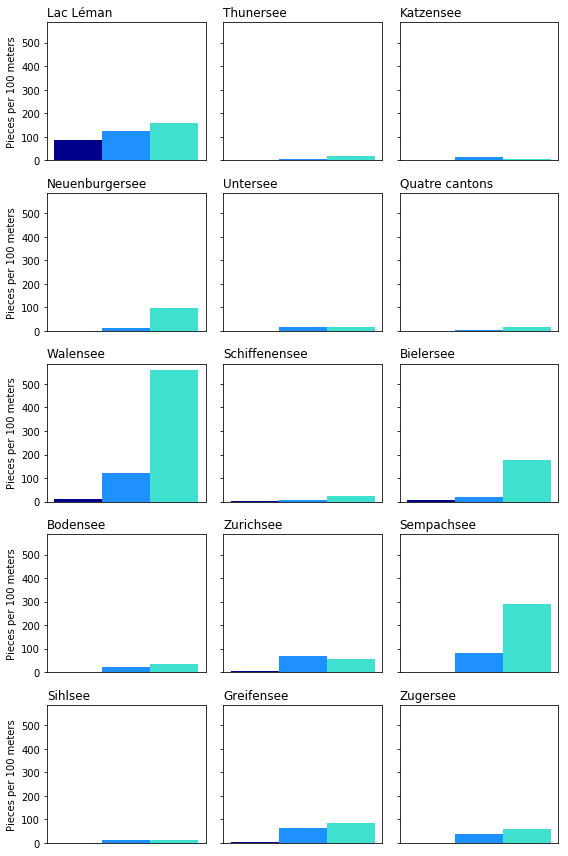

In [19]:
plot_groups(bars, data +'images/groups.svg',data +'images/groups.png', 4)

### Can't tell a whole lot from that so we will go ahead and look at the groups

In [20]:
dfConsumer = dfObj[consumer]

In [21]:
dfConsumer.columns

Index(['G30', 'G178', 'G21', 'G23', 'G31', 'G35'], dtype='object', name='code_id')

In [22]:
idx = pd.IndexSlice
def aver_lake_2(a,b):
    i = {}
    for key, value in a.items():
        h = {key:{}}
        c = b.loc[idx[:, value, :], :]
        j = list(c.columns)
        d = c.mean(axis=0).round(4)
        g = {j[0]:d[j[0]], j[1]:d[j[1]], j[2]:d[j[2]], j[3]:d[j[3]], j[4]:d[j[4]], j[5]:d[j[5]]}
        h[key].update(g)
        i.update(h)
    return i
    
cons_bars = aver_lake_2(lake_key,dfConsumer)

In [23]:
def plot_groups_cons(x, svgtitle, pngtitle, q):
    # number of rows depends on the number of weeks
    rows = 5
   
    # the number of columns depends on the number of locations
    cols = 3
    # this is the number of bars in each chart
    # this depends on the number of color groups
    ind = np.arange(1, q)#<--- this the number of bars
    # the width of each bar
    # width one means there is no space between bars
    width = 1
    # assign appropriate colors per group
    colss = ['darkblue', 'dodgerblue', 'turquoise', 'magenta', 'chartreuse','seagreen']
    # set up the figure and the array of charts
    f, axar = plt.subplots(rows, cols, figsize=(8,12), sharey=True)
    # run through the results generated by the previous fucntion
    for a, (key, value) in enumerate(x.items()):
        i = a%3
        j = a%5
        if i == 0:
            for label, number in value.items():
                axar[j, i].bar(ind, [value['G30'], value['G178'], value['G21'], value['G23'], value['G31'], value['G35']], width, color=colss)
                axar[j, i].set_title(key, loc='left')
                axar[j, i].set_xticklabels([])
                axar[j, i].set_ylabel('Pieces per 100 meters', fontdict=None,)
                axar[j, i].set_xticks([])
        else:
            for label, number in value.items():
                axar[j, i].bar(ind, [value['G30'], value['G178'], value['G21'], value['G23'], value['G31'], value['G35']], width, color=colss)
                axar[j, i].set_title(key, loc='left')
                axar[j, i].set_xticklabels([])
                axar[j, i].set_xticks([])
    
    plt.savefig(svgtitle)
    plt.savefig(pngtitle)
    plt.tight_layout()
    
    plt.show()

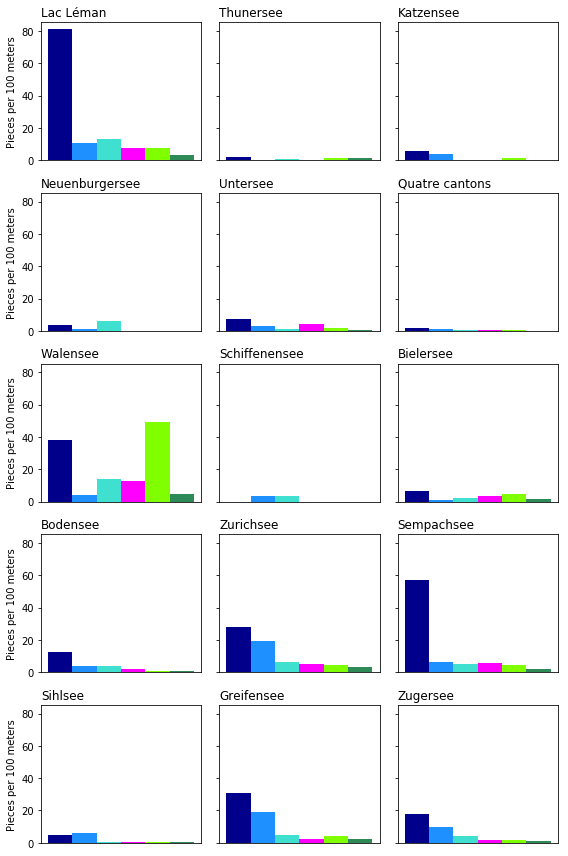

In [24]:
# seperate by lakes
plot_groups_cons(cons_bars, data +'images/cons_groups.svg',data +'images/cons_groups.png', 7)

In [25]:
dfInfra = dfObj[infra]

In [26]:
dfInfra.columns

Index(['G95', 'G96', 'G91', 'G144'], dtype='object', name='code_id')

In [27]:
idx = pd.IndexSlice
def aver_lake_3(a,b):
    i = {}
    for key, value in a.items():
        h = {key:{}}
        c = b.loc[idx[:, value, :], :]
        j = list(c.columns)
        d = c.mean(axis=0).round(4)
        g = {j[0]:d[j[0]], j[1]:d[j[1]], j[2]:d[j[2]], j[3]:d[j[3]]}
        h[key].update(g)
        i.update(h)
    return i
    
infra_bars = aver_lake_3(lake_key,dfInfra)

In [28]:
def plot_groups_infra(x, svgtitle, pngtitle, q):
    # number of rows depends on the number of weeks
    rows = 5
    # the number of columns depends on the number of locations
    cols = 3
    # this is the number of bars in each chart
    # this depends on the number of color groups
    ind = np.arange(1, q)#<--- this is the number of bars
    # the width of each bar
    # width one means there is no space between bars
    width = 1
    # assign appropriate colors per group
    colss = ['darkblue', 'dodgerblue', 'turquoise', 'magenta', 'chartreuse','seagreen']
    # set up the figure and the array of charts
    f, axar = plt.subplots(rows, cols, figsize=(8,12), sharey=True)
    # run through the results generated by the previous fucntion
    for a, (key, value) in enumerate(x.items()):
        i = a%3
        j = a%5
        if i == 0:
            for label, number in value.items():
                axar[j, i].bar(ind, [value['G95'], value['G96'], value['G91'], value['G144']], width, color=colss)
                axar[j, i].set_title(key, loc='left')
                axar[j, i].set_xticklabels([])
                axar[j, i].set_ylabel('Pieces per 100 meters', fontdict=None,)
                axar[j, i].set_xticks([])
        else:
            for label, number in value.items():
                axar[j, i].bar(ind, [value['G95'], value['G96'], value['G91'], value['G144']], width, color=colss)
                axar[j, i].set_title(key, loc='left')
                axar[j, i].set_xticklabels([])
                axar[j, i].set_xticks([])
 
    plt.savefig(svgtitle)
    plt.savefig(pngtitle)
    plt.tight_layout()
    
    plt.show()

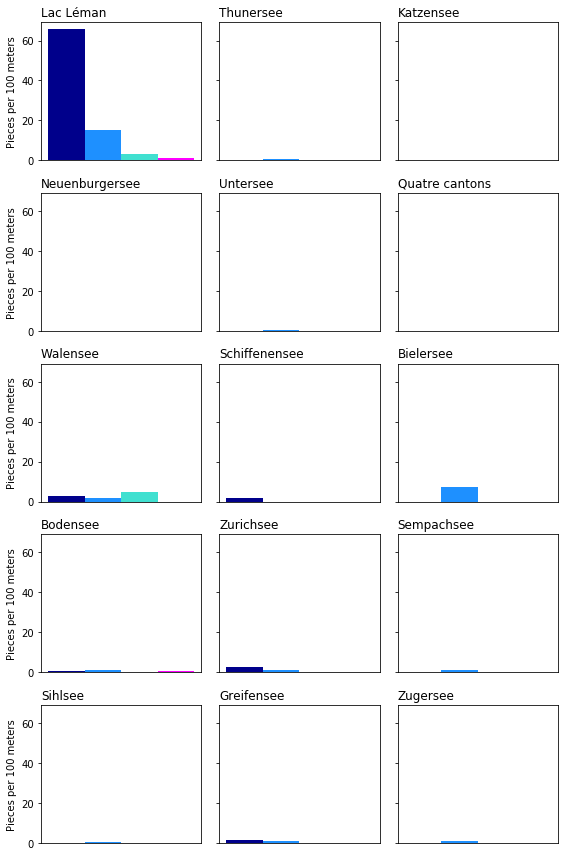

In [29]:
plot_groups_infra(infra_bars, data +'images/infra_groups.svg',data +'images/infra_groups.png', 5)

In [30]:
dfIndus = dfObj[industry]

In [31]:
dfIndus.columns

Index(['G67', 'G79', 'G82', 'G89'], dtype='object', name='code_id')

In [32]:
indus_bars = aver_lake_3(lake_key,dfIndus)

In [33]:
def plot_groups_indus(x, svgtitle, pngtitle, q):
    # number of rows depends on the number of weeks
    rows = 5
    # the number of columns depends on the number of locations
    cols = 3
    # this is the number of bars in each chart
    # this depends on the number of color groups
    ind = np.arange(1, q)#<--- this is the number of bars
    # the width of each bar
    # width one means there is no space between bars
    width = 1
    # assign appropriate colors per group
    colss = colss = ['darkblue', 'dodgerblue', 'turquoise', 'magenta', 'chartreuse','seagreen']
    # set up the figure and the array of charts
    f, axar = plt.subplots(rows, cols, figsize=(8,12), sharey=True)
    # run through the results generated by the previous fucntion
    for a, (key, value) in enumerate(x.items()):
        i = a%3
        j = a%5
        if i == 0:
            for label, number in value.items():
                axar[j, i].bar(ind, [value['G67'], value['G79'], value['G82'], value['G89']], width, color=colss)
                axar[j, i].set_title(key, loc='left')
                axar[j, i].set_xticklabels([])
                axar[j, i].set_ylabel('Pieces per 100 meters', fontdict=None,)
                axar[j, i].set_xticks([])
        else:
            for label, number in value.items():
                axar[j, i].bar(ind, [value['G67'], value['G79'], value['G82'], value['G89']], width, color=colss)
                axar[j, i].set_title(key, loc='left')
                axar[j, i].set_xticklabels([])
                axar[j, i].set_xticks([])    

    
    plt.savefig(svgtitle)
    plt.savefig(pngtitle)
    plt.tight_layout()
    
    plt.show()

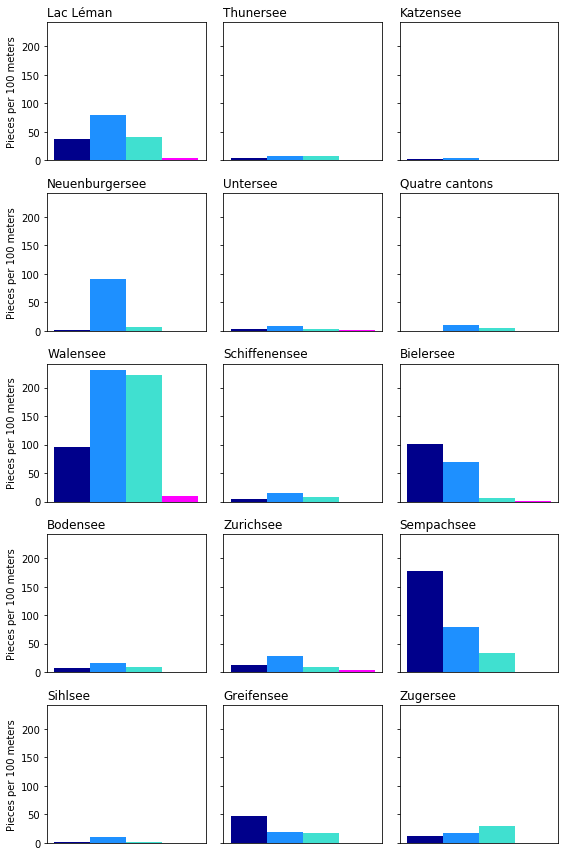

In [34]:
plot_groups_indus(indus_bars, data +'images/indus_groups.svg',data +'images/indus_groups.png', 5)